[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs/nnx/penguins_tutorial.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs/nnx/penguins_tutorial.ipynb)

# Penguins Tutorial

Welcome to NNX! This tutorial will guide you through building and training a simple
neural network on the Penguins dataset using the NNX API. NNX is a Python neural network library
built upon [JAX](https://github.com/google/jax) and currently offered as an experimental module within
[Flax](https://github.com/google/flax).

## 1. Install NNX

Since NNX is under active development, we recommend using the latest version from the Flax GitHub repository:

In [1]:
# !pip install git+https://github.com/google/flax.git

## 2. Load the Penguins Dataset

First, the Penguins dataset is loaded and prepared for training and testing using
Tensorflow Datasets. [Penguins](https://www.tensorflow.org/datasets/catalog/penguins) dataset is available in 3 different version:
* [penguins/processed](https://www.tensorflow.org/datasets/catalog/penguins#penguinsprocessed_default_config)
* [penguins/simple](https://www.tensorflow.org/datasets/catalog/penguins#penguinssimple)
* [penguins/raw](https://www.tensorflow.org/datasets/catalog/penguins#penguinsraw)

For simplisity, we will use `penguins/processed` version which contains 4 normalised numerical features presented as a single tensor, no missing values and the class label (species) is presented as an integer (n = 334).

In [2]:
import tensorflow_datasets as tfds  # TFDS for Penguins
import matplotlib.pyplot as plt

# original link: https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0].batch(32, drop_remainder=True)
ds_train = ds_split[1].batch(32, drop_remainder=True)

Let's visualize some clusters by plotting a few features from the batch:

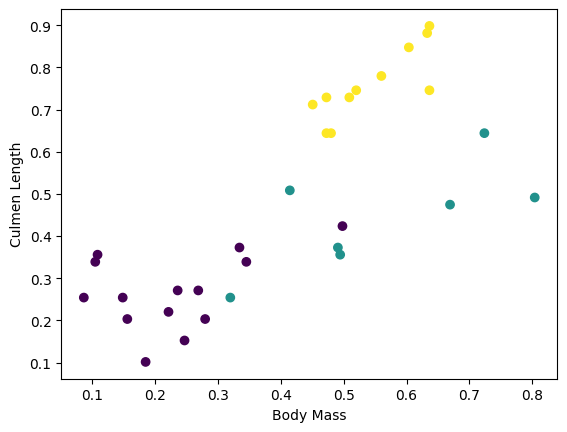

In [3]:
features, labels = next(iter(ds_train))

plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

## 3. Define the Network with NNX

Create a DNN with NNX by subclassing `nnx.Module`.

In [4]:
from flax import nnx  # NNX API

class SimpleDNN(nnx.Module):
  """A simple DNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear( 4, 10, rngs=rngs)
    self.linear2 = nnx.Linear(10, 10, rngs=rngs)
    self.linear3 = nnx.Linear(10,  3, rngs=rngs)

  def __call__(self, x):
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    x = self.linear3(x)
    return x

model = SimpleDNN(rngs=nnx.Rngs(0))
nnx.display(model)

SimpleDNN(
  linear1=Linear(
    kernel=Param(
      value=Array(shape=(4, 10), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(10,), dtype=float32)
    ),
    in_features=4,
    out_features=10,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x781f560c53f0>,
    bias_init=<function zeros at 0x781f6575d090>,
    dot_general=<function dot_general at 0x781f65e95090>
  ),
  linear2=Linear(
    kernel=Param(
      value=Array(shape=(10, 10), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(10,), dtype=float32)
    ),
    in_features=10,
    out_features=10,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x781f560c53f0>,
    bias_init=<function zeros at 0x781f6575d090>,
    dot_general=<function dot_general at 0x781f65e95090>
  ),
  linear3

### Run model

Let's put our model to the test!  We'll perform a forward pass with arbitrary data and print the results.

In [5]:
import jax

y = model(jax.random.normal(jax.random.PRNGKey(0), (5, 4)))
nnx.display(y)
nnx.display(nnx.softmax(y))

[[-0.5253621   0.18314967 -0.05993876]
 [-0.9001121   0.33735085 -0.10472799]
 [-0.3428089   0.8227411  -0.2038013 ]
 [-0.4054175   0.53169316 -0.374483  ]
 [-0.06584015  1.3513488  -1.0331334 ]]
[[0.21627913 0.43925563 0.34446523]
 [0.1501017  0.5173792  0.3325191 ]
 [0.18667795 0.59880435 0.21451774]
 [0.21814944 0.5568473  0.22500324]
 [0.18163268 0.7493269  0.06904049]]


## 4. Create Optimizer and Metrics

In NNX, we create an `Optimizer` object to manage the model's parameters and apply gradients during training. `Optimizer` receives the model's reference so it can update its parameters, and an `optax` optimizer to define the update rules. Additionally, we'll define a `MultiMetric` object to keep track of the `Accuracy` and the `Average` loss.

In [6]:
import optax

# using the same optimizer as used by https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#create_an_optimizer
# but more optimizers are available, check https://optax.readthedocs.io/en/latest/api/optimizers.html for the full list.
optimizer = nnx.Optimizer(model, optax.sgd(learning_rate=0.05))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

## 5. Define step functions

We define a loss function using cross entropy loss (see more details in [`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.softmax_cross_entropy_with_integer_labels)) that our model will optimize over. In addition to the loss, the logits are also outputted since they will be used to calculate the accuracy metric during training and testing. During training, we'll use `nnx.value_and_grad` to compute the gradients and update the model's parameters using the optimizer. During both training and testing, the loss and logits are used to calculate the metrics.

In [7]:
def loss_fn(model: SimpleDNN, data, labels):
  logits = model(data)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=labels
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: SimpleDNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, data, labels):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, data, labels)
  metrics.update(loss=loss, logits=logits, labels=labels)  # inplace updates
  optimizer.update(grads)  # inplace updates

@nnx.jit
def eval_step(model: SimpleDNN, metrics: nnx.MultiMetric, data, labels):
  loss, logits = loss_fn(model, data, labels)
  metrics.update(loss=loss, logits=logits, labels=labels)

The [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/transforms.html#flax.nnx.jit) decorator traces the `train_step` function for just-in-time compilation with
[XLA](https://www.tensorflow.org/xla), optimizing performance on
hardware accelerators. `nnx.jit` is similar to [`jax.jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit),
except it can transforms functions that contain NNX objects as inputs and outputs.

**NOTE**: in the above code we performed serveral inplace updates to the model, optimizer, and metrics, and we did not explicitely return the state updates. This is because NNX transforms respect reference semantics for NNX objects, and will propagate the state updates of the objects passed as input arguments. This is a key feature of NNX that allows for a more concise and readable code.

## 6. Train and Evaluate

Now we train a model using batches of data for 10 epochs, evaluate its performance
on the test set after each epoch, and log the training and testing metrics (loss and
accuracy) throughout the process. Typically this leads to a model with around 99% accuracy.

In [8]:
# Keep results for plotting
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

num_epochs = 201

for epoch in range(num_epochs):
  for x, y in ds_train.as_numpy_iterator():
    # Optimize the model
    train_step(model, optimizer, metrics, x, y)
  for metric, value in metrics.compute().items():  # compute metrics
    metrics_history[f'train_{metric}'].append(value)  # record metrics
    if epoch % 50 == 0:
      print(f"[train] epoch[{epoch}]: {metric}: {value:.3f}")
  metrics.reset()  # reset metrics for test set

  for test_x, test_y in ds_test.as_numpy_iterator():
    eval_step(model, metrics, test_x, test_y)

  for metric, value in metrics.compute().items():  # compute metrics
    metrics_history[f'test_{metric}'].append(value)  # record metrics
    if epoch % 50 == 0:
      print(f"[test] epoch[{epoch}]: {metric}: {value:.3f}")
  metrics.reset()  # reset metrics for test set

[train] epoch[0]: accuracy: 0.191
[train] epoch[0]: loss: 1.115
[test] epoch[0]: accuracy: 0.219
[test] epoch[0]: loss: 1.091
[train] epoch[50]: accuracy: 0.812
[train] epoch[50]: loss: 0.402
[test] epoch[50]: accuracy: 0.766
[test] epoch[50]: loss: 0.442
[train] epoch[100]: accuracy: 0.812
[train] epoch[100]: loss: 0.371
[test] epoch[100]: accuracy: 0.766
[test] epoch[100]: loss: 0.406
[train] epoch[150]: accuracy: 0.949
[train] epoch[150]: loss: 0.176
[test] epoch[150]: accuracy: 0.953
[test] epoch[150]: loss: 0.159
[train] epoch[200]: accuracy: 0.969
[train] epoch[200]: loss: 0.075
[test] epoch[200]: accuracy: 0.984
[test] epoch[200]: loss: 0.056


## 7. Visualize Metrics

Use Matplotlib to create plots for loss and accuracy.

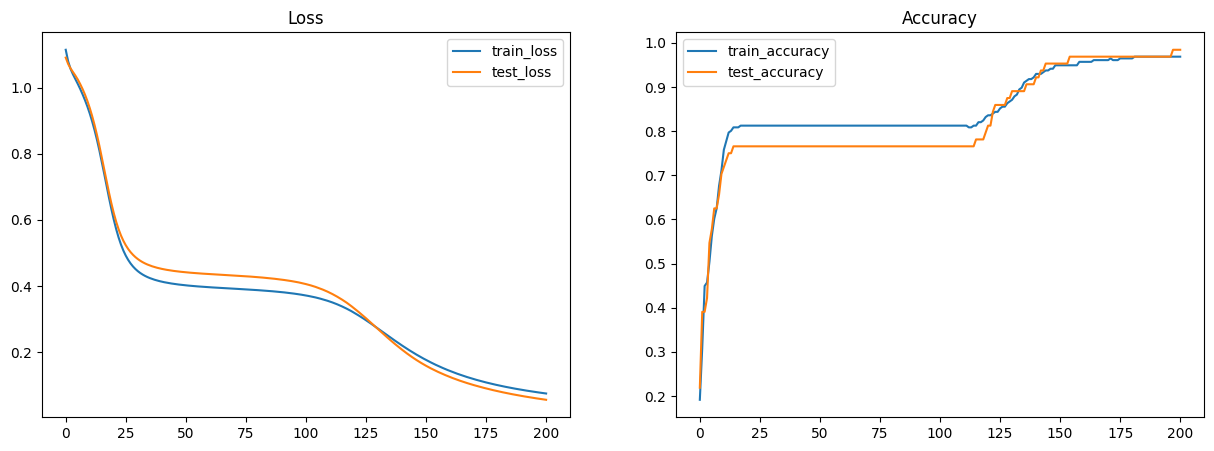

In [9]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 8. Perform inference on test examples

Define a jitted inference function, `pred_step`, to generate predictions on the test examples using the learned model parameters.

In [16]:
import jax.numpy as jnp

@nnx.jit
def pred_step(model: SimpleDNN, batch):
  logits = model(batch)
  cls = logits.argmax(axis=1)
  return cls, jnp.take_along_axis(nnx.softmax(logits, axis=1), cls[..., None], axis=1), logits

In [19]:
predict_dataset = jnp.array([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

predictions = pred_step(model, predict_dataset)
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

for i,  (class_idx, prob, logits) in enumerate(zip(*predictions)):
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*prob[0]))

Example 0 prediction: Adélie (99.4%)
Example 1 prediction: Gentoo (99.4%)
Example 2 prediction: Chinstrap (94.4%)


#Saving Models

In [23]:
import orbax.checkpoint as orbax

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save('/tmp/penguins-state', nnx.state(model), force=True)

#Loading Models

In [42]:
restored_model = SimpleDNN(rngs=nnx.Rngs(0))
restored_state = checkpointer.restore('/tmp/penguins-state', item=nnx.state(restored_model))
nnx.update(restored_model, restored_state)

/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1442: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Validate restored model

Now, let's check if restored model produces the same results as an original model

In [44]:
predictions_by_original_model = pred_step(model, predict_dataset)
predictions_by_restored_model = pred_step(restored_model, predict_dataset)

print("Predictions by original model")
print(predictions_by_original_model[2])
print("Predictions by restored model")
print(predictions_by_restored_model[2])
jnp.allclose(predictions_by_original_model[2], predictions_by_restored_model[2])

Predictions by original model
[[ 7.665731    2.4766412  -7.28208   ]
 [-5.676718    0.1893698   5.245333  ]
 [ 0.24301164  3.123489   -2.6841788 ]]
Predictions by restored model
[[ 7.665731    2.4766412  -7.28208   ]
 [-5.676718    0.1893698   5.245333  ]
 [ 0.24301164  3.123489   -2.6841788 ]]


Array(True, dtype=bool)

Congratulations! You made it to the end of the annotated Penguins example.